In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

np.random.seed(2)

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import Input

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fer2013.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
groups = [g for _, g in data.groupby('Usage')]
train = groups[2]
val = groups[1]
test = groups[0]

In [5]:
train = train.drop(labels=['Usage'], axis=1)
val = val.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

Y_train = train["emotion"]
Y_val = val["emotion"]
Y_test = test["emotion"]
#'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'#

X_train = train["pixels"]
X_val = val["pixels"]
X_test = test["pixels"]

In [6]:
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [7]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

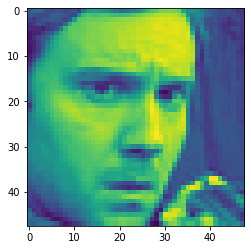

In [8]:
plt.imshow(X_train[0][:,:,0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Counts per emotion in testing set')

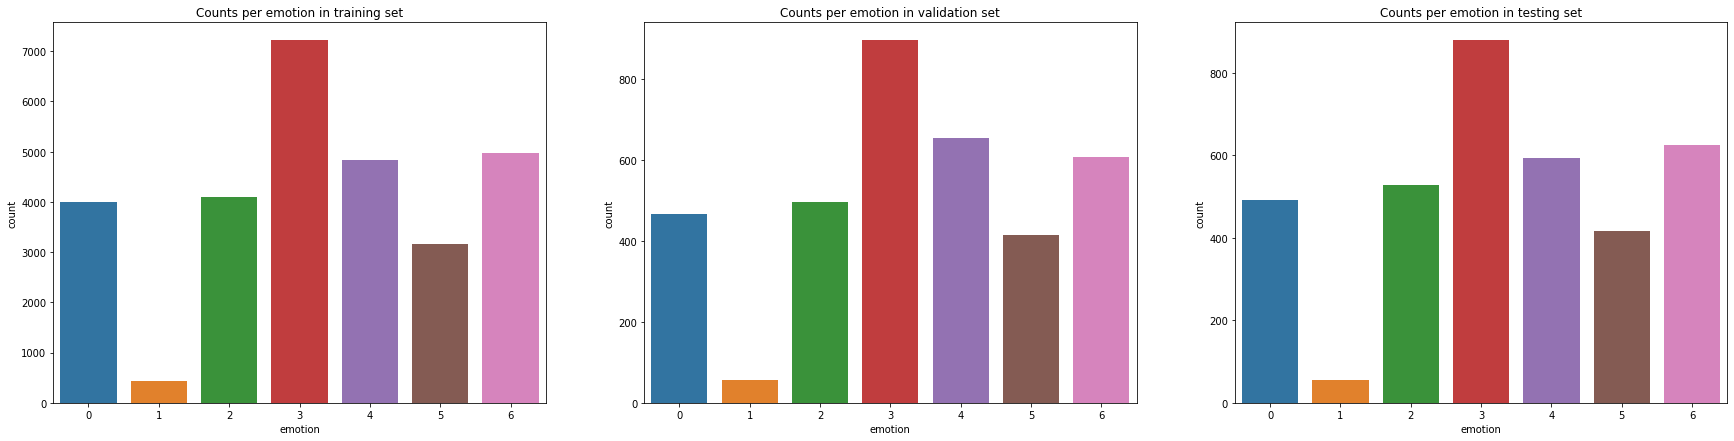

In [9]:
plt.figure(figsize=(30, 7))

plt.subplot(1,3,1)
ax = sns.countplot(Y_train)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in training set")

plt.subplot(1,3,2)
ax = sns.countplot(Y_val)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in validation set")

plt.subplot(1,3,3)
ax = sns.countplot(Y_test)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in testing set")

In [10]:
Y_train = to_categorical(Y_train, num_classes=7)
Y_val = to_categorical(Y_val, num_classes=7)
Y_test = to_categorical(Y_test, num_classes=7)

In [11]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="Same", activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [12]:
optimizer = opt.Adam(lr = 0.001)
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)

In [13]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size = 100, callbacks=[lr_anneal])

Epoch 1/100
288/288 [==============================] - 43s 31ms/step - loss: 2.7167 - accuracy: 0.2252 - val_loss: 1.8574 - val_accuracy: 0.2513
Epoch 2/100
288/288 [==============================] - 8s 28ms/step - loss: 1.7114 - accuracy: 0.3074 - val_loss: 1.6874 - val_accuracy: 0.3330
Epoch 3/100
288/288 [==============================] - 8s 28ms/step - loss: 1.5231 - accuracy: 0.3950 - val_loss: 1.3768 - val_accuracy: 0.4539
Epoch 4/100
288/288 [==============================] - 8s 28ms/step - loss: 1.3707 - accuracy: 0.4633 - val_loss: 1.3125 - val_accuracy: 0.4901
Epoch 5/100
288/288 [==============================] - 8s 29ms/step - loss: 1.2907 - accuracy: 0.5015 - val_loss: 1.2829 - val_accuracy: 0.5091
Epoch 6/100
288/288 [==============================] - 8s 29ms/step - loss: 1.2410 - accuracy: 0.5263 - val_loss: 1.2795 - val_accuracy: 0.5057
Epoch 7/100
288/288 [==============================] - 8s 29ms/step - loss: 1.1899 - accuracy: 0.5469 - val_loss: 1.1928 - val_accuracy

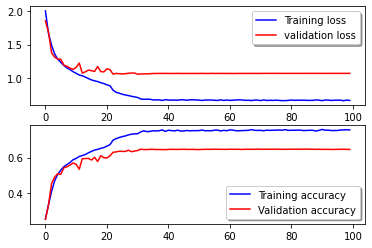

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

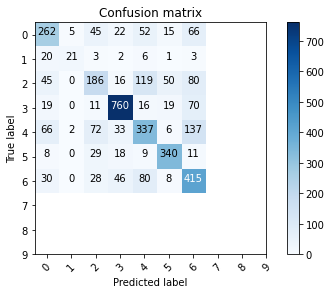

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [17]:
score, acc = model.evaluate(X_test, Y_test, batch_size=100)
print('Test score:', score)
print("Test accuracy:", acc)

36/36 [==============================] - 0s 9ms/step - loss: 1.0181 - accuracy: 0.6598
Test score: 1.0181373357772827
Test accuracy: 0.6597937941551208
